# Import packages

In [1]:
import numpy as np
import pandas as pd
import patsy.version
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import math
import patsy 
from causalml.inference.tf import DragonNet
from causalml.dataset.regression import *
from causalml.metrics import *
import scipy
import random
import tensorflow as tf

c:\Users\ASUS\anaconda3\envs\causalml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


# Import data

In [2]:
data = pd.read_csv("C:/Users/ASUS/Desktop/cg working/CausalML/simulation data_DTR/for plan/simulation data(cont.).csv")
data_train, data_test=train_test_split(data,test_size=0.2,random_state=91626)
data_train

,id,bloc,true_ite(Dsofa),Dsofa,Treat,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
6472,6473,0,2.709445,0.886266,0,0,0.254906,0.944751,-0.074629,3.269318,-0.665121,1.202297,-0.828230,0.621825,0.009106
3205,3206,0,0.017198,-0.843444,1,1,0.218906,-3.408251,0.368003,0.363680,1.160311,-0.020015,0.507427,2.545446,0.870314
6450,6451,0,2.564387,1.333829,0,0,0.575765,1.620563,-2.195253,-0.449026,0.446350,-1.049989,1.228228,1.017968,-1.040547
1456,1457,0,2.612925,-0.518554,1,0,0.443885,0.959867,0.328732,0.750321,-1.653634,-1.825425,-2.144697,0.071179,2.517118
4083,4084,0,0.674369,0.251665,0,0,-0.220555,0.331547,1.500219,-0.189197,0.337513,0.983597,1.151011,-0.790246,-1.424898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,4183,0,1.072251,-0.596314,0,0,1.112723,0.128331,-0.828687,-0.745687,-1.491760,-0.843627,-0.893345,-0.229870,1.381539
5082,5083,0,0.232651,-0.743816,0,1,-0.096516,-0.372164,-0.962702,-0.070504,-0.627134,-0.815309,0.939247,0.523982,-1.652024
3379,3380,0,2.580364,1.005855,1,1,1.618848,0.171271,0.891289,-0.242350,-0.449774,1.096188,0.589630,-1.907868,-0.284011
6824,6825,0,0.088212,-0.760578,1,1,-0.104243,-0.991804,-1.424458,-0.186849,0.471382,-0.218532,-0.975700,1.470087,-0.669636


In [3]:
data3_train=data_train.drop(columns=["bloc","id","true_ite(Dsofa)"])
data3_test=data_test
data3_train=data3_train.reset_index(drop=True)
data3_test=data3_test.reset_index(drop=True)

n=data3_train.shape[0]
p=data3_train.shape[1]-2
sqrt_p=math.floor(p**0.5)
dv3_p=math.floor(p/3)
view={"":["training set","testing set"],
      "Dsofa_mean":[sum(data3_train["Dsofa"])/n,sum(data3_test["Dsofa"])/n*4],
      "Treat_prop":[sum(data3_train["Treat"])/n,sum(data3_test["Treat"])/n*4]}
view=pd.DataFrame(view)
view

,,Dsofa_mean,Treat_prop
0,training set,0.576487,0.460000
1,testing set,0.664697,0.458667


# --------------------DoubleML (PLR)--------------------

In [4]:
#analysis2-3
data2_train=data_train.drop(columns=["bloc","id","true_ite(Dsofa)"])
data2_test=data_test
data2_train=data2_train.reset_index(drop=True)
data2_test=data2_test.reset_index(drop=True)
RFr_l=RandomForestRegressor(n_estimators=500,max_features=dv3_p,max_depth=None)
RFr_m=RandomForestClassifier(n_estimators=500,max_features=sqrt_p,max_depth=None)
obj_data2=dml.DoubleMLData(data2_train,"Dsofa","Treat")
np.random.seed(62619)
dml_irm_obj=dml.DoubleMLPLR(obj_data2,RFr_l,RFr_m)
result2_3=dml_irm_obj.fit(store_predictions=True)
a2_3=result2_3.nuisance_loss["ml_l"][0]
b2_3=result2_3.nuisance_loss["ml_m"][0]
c2_3=result2_3.coef

residm2_3=list(range(n))
residm2_3sq=list(range(n))
for i in range(n):
    def dblresid(y_true,y_pred):
        ans=y_true[0,i]-y_pred[0,i]
        return ans
    residm=dml_irm_obj.evaluate_learners(learners=["ml_m"],metric=dblresid)
    residm2_3[i]=residm["ml_m"][0]
    residm2_3sq[i]=residm["ml_m"][0]**2

predl2_3=list(range(n))
for i in range(n):
    def dblpred(y_true,y_pred):
        ans=y_pred[0,i]
        return ans
    predm=dml_irm_obj.evaluate_learners(learners=["ml_l"],metric=dblpred)
    predl2_3[i]=predm["ml_l"][0]

pred2_3=pd.DataFrame({"pred2_3":[0]*n})
pred2_3mean=pd.DataFrame(np.array(predl2_3+c2_3*residm2_3))
pred2_3mean.columns=list("p")
result2_3_RMSE=sum((np.array(data2_train["Dsofa"])-np.array(pred2_3mean["p"]))**2)/n
result2_3_RMSE=result2_3_RMSE**0.5

temp={"ite":[c2_3]*n,
       "w":data2_train["Treat"],
       "y":data2_train["Dsofa"]}
iteplr=pd.DataFrame(temp)
AUUCplr=auuc_score(iteplr)

# CATE

        0         1         2         3         4         5
0     1.0  0.000000  0.187211  0.783244  0.029545  0.000000
1     1.0  0.000000  0.221085  0.756810  0.022105  0.000000
2     1.0  0.000000  0.009663  0.846899  0.143439  0.000000
3     1.0  0.000000  0.055571  0.858160  0.086269  0.000000
4     1.0  0.016812  0.749043  0.234145  0.000000  0.000000
...   ...       ...       ...       ...       ...       ...
5995  1.0  0.000000  0.000000  0.575457  0.400377  0.024167
5996  1.0  0.002772  0.619718  0.377511  0.000000  0.000000
5997  1.0  0.000000  0.000000  0.358712  0.530259  0.111029
5998  1.0  0.003300  0.629115  0.367585  0.000000  0.000000
5999  1.0  0.248883  0.748729  0.000000  0.000000  0.000000

[6000 rows x 6 columns]
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t     P>|t|    [0.025    0.975]
0 -1.190316  1.372637 -0.867174  0.385881 -3.881178  1.500547
1  1.230606  1.729421  

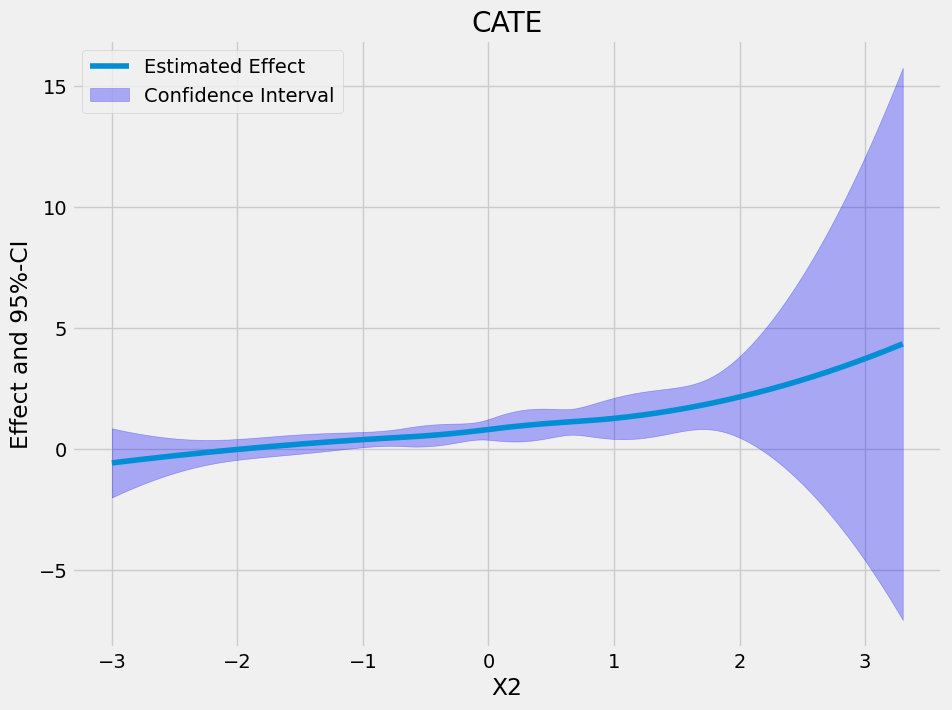

In [5]:
#cate2-3------------------------------------------------------------------------------------------------------------
design_matrix = patsy.dmatrix("bs(X2, df=5, degree=2)", {"X2": data2_train["X2"]})
spline_basis = pd.DataFrame(design_matrix)
print(spline_basis)
cate = dml_irm_obj.cate(spline_basis)
print(cate)

new_data = {"X2": np.linspace(-3, 3.3, 500)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
np.random.seed(1212)
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

#plot cate2_3
plt.rcParams['figure.figsize'] = 10.0, 7.5
df_cate['X2'] = new_data['X2']
fig, ax = plt.subplots()
ax.plot(df_cate['X2'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['X2'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('X2')
_ =  plt.ylabel('Effect and 95%-CI')
plt.show()

# --------------------DoubleML (IRM)--------------------

In [6]:
#analysis3_2
RFr_g=RandomForestRegressor(n_estimators=500,max_features=dv3_p+1,max_depth=None)
RFr_m=RandomForestClassifier(n_estimators=500,max_features=sqrt_p,max_depth=None)
obj_data3=dml.DoubleMLData(data3_train,"Dsofa","Treat")
np.random.seed(62619)
dml_irm_obj=dml.DoubleMLIRM(obj_data3,RFr_g,RFr_m)
result3_2=dml_irm_obj.fit(store_predictions=True)
a3_2=result3_2.nuisance_loss["ml_g1"][0]
aa3_2=result3_2.nuisance_loss["ml_g0"][0]
b3_2=result3_2.nuisance_loss["ml_m"][0]
c3_2=result3_2.coef

residm3_2=list(range(n))
residm3_2sq=list(range(n))
for i in range(n):
    def dblresid(y_true,y_pred):
        ans=y_true[0,i]-y_pred[0,i]
        return ans
    residm=dml_irm_obj.evaluate_learners(learners=["ml_m"],metric=dblresid)
    residm3_2[i]=residm["ml_m"][0]
    residm3_2sq[i]=residm["ml_m"][0]**2

predg3_2=list(range(n))
for i in range(n):
    def dblpred(y_true,y_pred):
        ans=y_pred[0,i]
        return ans
    predm=dml_irm_obj.evaluate_learners(learners=["ml_g1"],metric=dblpred)
    predg3_2[i]=predm["ml_g1"][0]

predgg3_2=list(range(n))
for i in range(n):
    def dblpred(y_true,y_pred):
        ans=y_pred[0,i]
        return ans
    predm=dml_irm_obj.evaluate_learners(learners=["ml_g0"],metric=dblpred)
    predgg3_2[i]=predm["ml_g0"][0]

pred3_2_1=pd.DataFrame({"pred3_2":[0]*n})
pred3_2_0=pd.DataFrame({"pred3_2":[0]*n})
pred3_2prob1=pd.DataFrame(np.array(predg3_2))
pred3_2prob1.columns=list("p")
pred3_2prob0=pd.DataFrame(np.array(predgg3_2))
pred3_2prob0.columns=list("p")

result3_2_1RMSE=(np.array(data3_train["Dsofa"])-np.array(pred3_2prob1["p"]))**2
result3_2_1RMSE=sum(result3_2_1RMSE[data3_train["Treat"]==1])/len(result3_2_1RMSE[data3_train["Treat"]==1])
result3_2_1RMSE=result3_2_1RMSE**0.5
result3_2_0RMSE=(np.array(data3_train["Dsofa"])-np.array(pred3_2prob0["p"]))**2
result3_2_0RMSE=sum(result3_2_0RMSE[data3_train["Treat"]==0])/len(result3_2_0RMSE[data3_train["Treat"]==0])
result3_2_0RMSE=result3_2_0RMSE**0.5

pred3_2prob_final=(np.array(data3_train["Treat"])*np.array(pred3_2prob1["p"]))+\
                  ((1-np.array(data3_train["Treat"]))*np.array(pred3_2prob0["p"]))
result3_2_RMSE_final=sum((np.array(data3_train["Dsofa"])-np.array(pred3_2prob_final))**2)/n
result3_2_RMSE_final=result3_2_RMSE_final**0.5

temp={"ite":pred3_2prob1["p"]-pred3_2prob0["p"],
       "w":data3_train["Treat"],
       "y":data3_train["Dsofa"]}
iteirm=pd.DataFrame(temp)
AUUCirm=auuc_score(iteirm)

# CATE

        0         1         2         3         4         5
0     1.0  0.000000  0.187211  0.783244  0.029545  0.000000
1     1.0  0.000000  0.221085  0.756810  0.022105  0.000000
2     1.0  0.000000  0.009663  0.846899  0.143439  0.000000
3     1.0  0.000000  0.055571  0.858160  0.086269  0.000000
4     1.0  0.016812  0.749043  0.234145  0.000000  0.000000
...   ...       ...       ...       ...       ...       ...
5995  1.0  0.000000  0.000000  0.575457  0.400377  0.024167
5996  1.0  0.002772  0.619718  0.377511  0.000000  0.000000
5997  1.0  0.000000  0.000000  0.358712  0.530259  0.111029
5998  1.0  0.003300  0.629115  0.367585  0.000000  0.000000
5999  1.0  0.248883  0.748729  0.000000  0.000000  0.000000

[6000 rows x 6 columns]
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t     P>|t|    [0.025     0.975]
0 -1.454532  1.932027 -0.752853  0.451568 -5.241999   2.332935
1  1.548609  2.435837

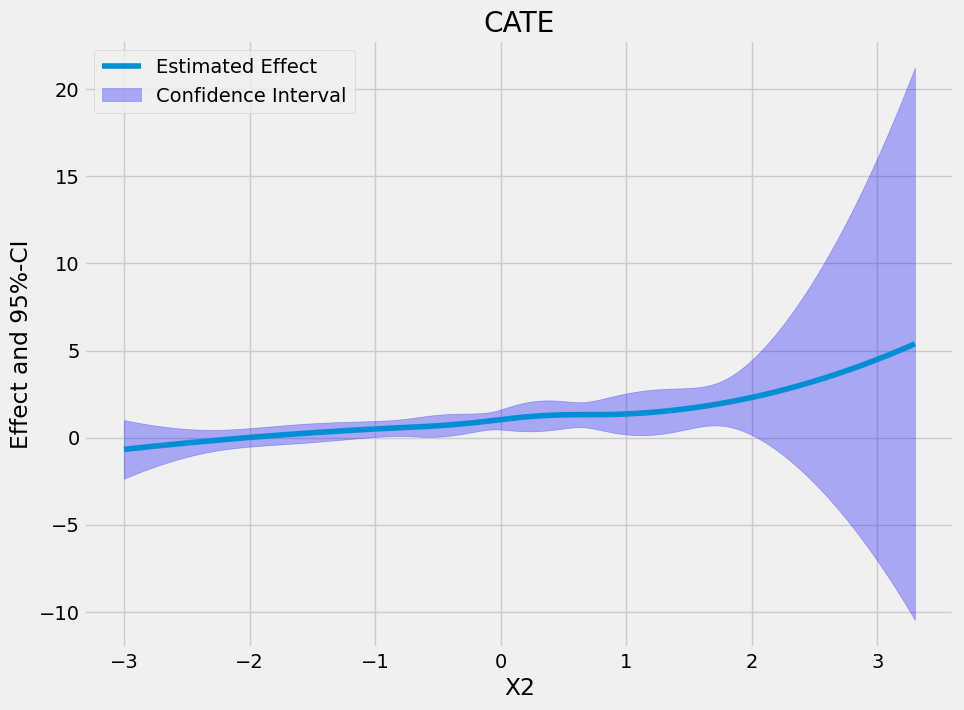

In [7]:
#cate3-2------------------------------------------------------------------------------------------------------------
design_matrix = patsy.dmatrix("bs(X2, df=5, degree=2)", {"X2": data3_train["X2"]})
spline_basis = pd.DataFrame(design_matrix)
print(spline_basis)
cate = dml_irm_obj.cate(spline_basis)
print(cate)

new_data = {"X2": np.linspace(-3, 3.3, 500)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
np.random.seed(1212)
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=5000)

#plot cate3-2
plt.rcParams['figure.figsize'] = 10.0, 7.5
df_cate['X2'] = new_data['X2']
fig, ax = plt.subplots()
ax.plot(df_cate['X2'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['X2'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

#CATE naive
iteirm_X={"X2":data3_train["X2"],
          "ITE":iteirm["ite"],
          "CATE":[0]*n}
iteirm_X=pd.DataFrame(iteirm_X)
iteirm_X=iteirm_X.sort_values(by="X2")
iteirm_X=iteirm_X.reset_index(drop=True)

ans=[]
for i in list(dict.fromkeys(iteirm_X["X2"])):
    tt=iteirm_X[iteirm_X["X2"]==i]
    mean=np.average(tt["ITE"])
    ans=ans+[mean]*tt.shape[0]

XX=[]
YY=[]
for i in list(range(100)):
    a=int(np.floor((n/100)*i))
    b=int(np.floor((n/100)*(i+1))-1)
    tt=iteirm_X.iloc[a:b]
    mean=np.average(tt["ITE"])
    YY=YY+[mean]
    XX=XX+[iteirm_X["X2"][b]]

plt.legend()
plt.title('CATE')
plt.xlabel('X2')
_ =  plt.ylabel('Effect and 95%-CI')
plt.show()

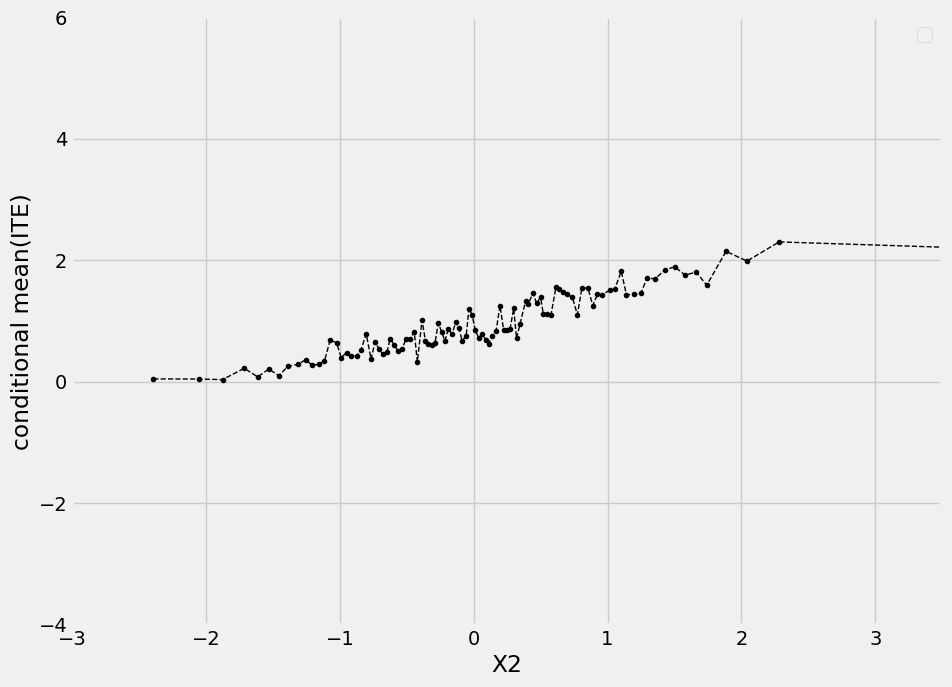

In [8]:
plt.legend()
plt.xlabel('X2')
_ =  plt.ylabel('conditional mean(ITE)')
plt.xlim(-3,3.5)
plt.ylim(-4,6)
plt.plot(pd.DataFrame(np.array(XX))[0],pd.DataFrame(np.array(YY))[0],marker=".",color="black",linestyle="--",linewidth=1)
plt.show()


# --------------------DragonNet--------------------

In [25]:
#analysis dragon
data4_train=data_train.drop(columns=["bloc","id","true_ite(Dsofa)"])
data4_train=data4_train.reset_index(drop=True)
X = data4_train.drop("Dsofa",axis=1)
X = X.drop("Treat",axis=1)
names=X.columns
#Normalization data
scaler=StandardScaler().fit(X)
X=scaler.transform(X)
X=pd.DataFrame(X)
X.columns=names

treatment = data4_train["Treat"]
treatment = treatment.astype("float")
y = data4_train['Dsofa']

def seed_every(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_every(1225)
dragon = DragonNet(neurons_per_layer=8, batch_size=256,epochs=300,adam_epochs=100)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

df_preds = pd.DataFrame([np.array(pred3_2prob1["p"]-pred3_2prob0["p"]),
                         dragon_ite.ravel(),
                         c2_3*np.array([1]*n),
                         treatment.ravel(),
                         y.ravel()],
                         index=["IRM",'dragonnet',"PLR",'w','y']).T



Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_classification_loss: 177.0973 - loss: 1943.6887 - regression_loss: 883.4002 - track_epsilon: 0.0059 - treatment_accuracy: 0.5390 - val_binary_classification_loss: 165.9838 - val_loss: 1928.5054 - val_regression_loss: 904.0522 - val_track_epsilon: 0.0180 - val_treatment_accuracy: 0.5333 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_classification_loss: 176.6535 - loss: 1850.2885 - regression_loss: 837.1851 - track_epsilon: 0.0210 - treatment_accuracy: 0.5362 - val_binary_classification_loss: 165.4023 - val_loss: 1825.7494 - val_regression_loss: 850.8508 - val_track_epsilon: 0.0290 - val_treatment_accuracy: 0.5333 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_classification_loss: 175.8559 - loss: 1771.7987 - regression_loss: 797.2682 - track_epsilon: 0.0300 - treatment_accuracy: 0.5362 - val_binary_classification_loss: 164.0591 - val_loss: 1730.9233 - v

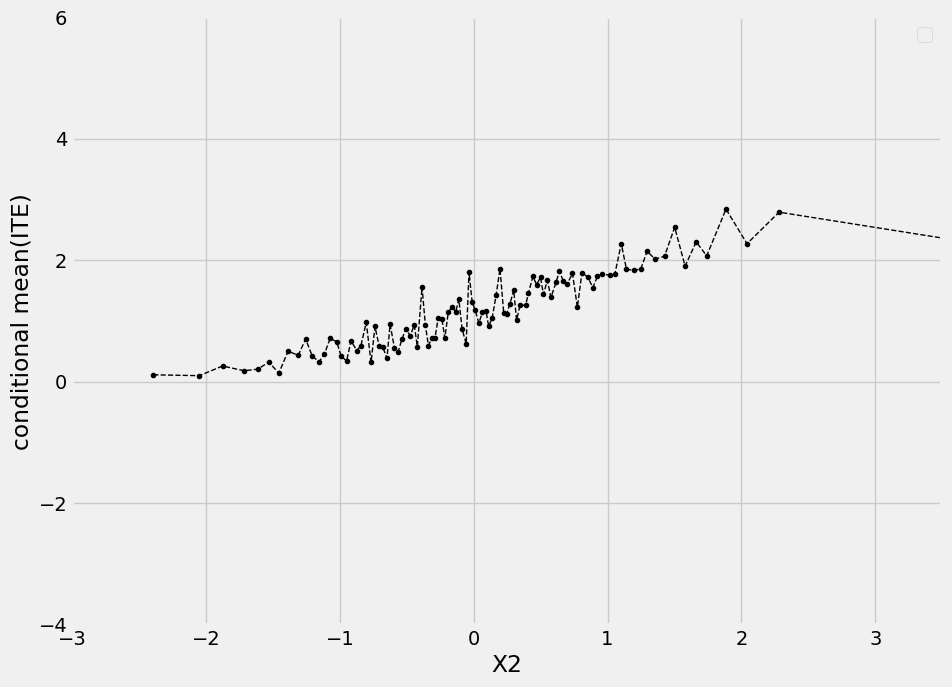

In [26]:
#CATE naive
itedragon_X={"X2":data4_train["X2"],
          "ITE":df_preds["dragonnet"],
          "CATE":[0]*n}
itedragon_X=pd.DataFrame(itedragon_X)
itedragon_X=itedragon_X.sort_values(by="X2")
itedragon_X=itedragon_X.reset_index(drop=True)

ans=[]
for i in list(dict.fromkeys(itedragon_X["X2"])):
    tt=itedragon_X[itedragon_X["X2"]==i]
    mean=np.average(tt["ITE"])
    ans=ans+[mean]*tt.shape[0]
itedragon_X["CATE"]=ans

XX=[]
YY=[]
for i in list(range(100)):
    a=int(np.floor((n/100)*i))
    b=int(np.floor((n/100)*(i+1))-1)
    tt=itedragon_X.iloc[a:b]
    mean=np.average(tt["ITE"])
    YY=YY+[mean]
    XX=XX+[itedragon_X["X2"][b]]


plt.legend()
plt.xlabel('X2')
_ =  plt.ylabel('conditional mean(ITE)')
plt.xlim(-3,3.5)
plt.ylim(-4,6)
plt.plot(pd.DataFrame(np.array(XX))[0],pd.DataFrame(np.array(YY))[0],marker=".",color="black",linestyle="--",linewidth=1)
plt.show()

# --------------------Results--------------------

# Uplift curve compare

           IRM  dragonnet       PLR    w         y
0     1.159044   2.275507  0.851104  0.0  0.886266
1    -1.282965  -0.077097  0.851104  1.0 -0.843444
2     2.464816   1.780222  0.851104  0.0  1.333829
3     3.139004   0.904700  0.851104  1.0 -0.518554
4     0.774395   0.465482  0.851104  0.0  0.251665
...        ...        ...       ...  ...       ...
5995  0.967404   0.609691  0.851104  0.0 -0.596314
5996 -0.002902   0.155569  0.851104  0.0 -0.743816
5997  1.659155   3.271191  0.851104  1.0  1.005855
5998  0.181183  -0.006674  0.851104  1.0 -0.760578
5999 -0.318184  -0.004460  0.851104  1.0  2.359601

[6000 rows x 5 columns]


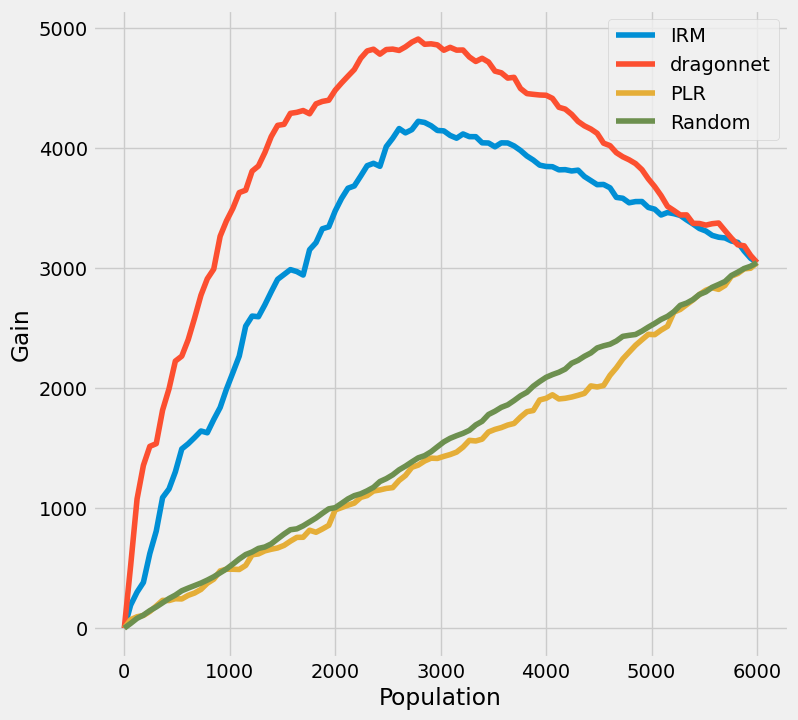

In [27]:
print(df_preds)
plt.rcParams['figure.figsize'] = 10.0, 7.5
plot_gain(df_preds)
plt.show()

# ATE compare 1

In [28]:
data_train=data_train.reset_index(drop=True)
dragonresult=df_preds.drop(columns=["PLR","IRM"])
draggonpred=pd.DataFrame(dragon.predict(X, treatment, y))
residdrag1=(data4_train["Dsofa"]-draggonpred[1])*data4_train["Treat"]
residdrag0=(data4_train["Dsofa"]-draggonpred[0])*(1-data4_train["Treat"])
RMSEdrag=sum((residdrag1+residdrag0)**2)/n
RMSEdrag=RMSEdrag**0.5
dragon_final_p=(draggonpred[1])*data4_train["Treat"]+(draggonpred[0])*(1-data4_train["Treat"])

table_total={"training set":["ATE","pvalue","AUUC","RMSE_total","ite_bias"],
       "PLR":[c2_3[0],result2_3.pval[0],AUUCplr[0],result2_3_RMSE,\
              np.sqrt((sum((c2_3-data_train["true_ite(Dsofa)"])**2))/n)],
       "IRM":[c3_2[0],result3_2.pval[0],AUUCirm[0],result3_2_RMSE_final,\
              np.sqrt((sum((pred3_2prob1["p"]-pred3_2prob0["p"]-data_train["true_ite(Dsofa)"])**2))/n)],
       "DragonNet":[dragon_ate,".",auuc_score(dragonresult)[0],RMSEdrag,\
                    np.sqrt((sum((draggonpred[1]-draggonpred[0]-data_train["true_ite(Dsofa)"])**2))/n)]}
table_total=pd.DataFrame(table_total)
print(f"true ATE:{1.0012}")
table_total


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
true ATE:1.0012


,training set,PLR,IRM,DragonNet
0,ATE,8.511042e-01,1.005201e+00,1.184202
1,pvalue,1.009607e-41,4.580852e-42,.
2,AUUC,4.734194e-01,1.040843e+00,1.263533
3,RMSE_total,1.845530e+00,1.807440e+00,1.710434
4,ite_bias,1.089391e+00,7.083474e-01,1.000729


# ATE compare 2 (trying)

In [29]:
term1=dragonresult["dragonnet"]
term2=data4_train["Treat"]/draggonpred[2]-(1-data4_train["Treat"])/(1-draggonpred[2])
term3=data4_train["Dsofa"]-(data4_train["Treat"]*draggonpred[1]+(1-data4_train["Treat"])*draggonpred[0])
scorefunction=term1+term2*term3
phi=np.average(term1+term2*term3)
dgpvalue=np.sqrt((phi**2)/np.var(scorefunction)*n)
dgpvalue=1-scipy.stats.norm.cdf(dgpvalue)+scipy.stats.norm.cdf(-dgpvalue)
table_total={"training set":["ATE","pvalue","AUUC","RMSE_total","ite_bias"],
       "PLR":[c2_3[0],result2_3.pval[0],AUUCplr[0],result2_3_RMSE,\
              np.sqrt((sum((c2_3-data_train["true_ite(Dsofa)"])**2))/n)],
       "IRM":[c3_2[0],result3_2.pval[0],AUUCirm[0],result3_2_RMSE_final,\
              np.sqrt((sum((pred3_2prob1["p"]-pred3_2prob0["p"]-data_train["true_ite(Dsofa)"])**2))/n)],
       "DragonNet":[phi,dgpvalue,auuc_score(dragonresult)[0],RMSEdrag,\
                    np.sqrt((sum((draggonpred[1]-draggonpred[0]-data_train["true_ite(Dsofa)"])**2))/n)]}
table_total=pd.DataFrame(table_total)
print(f"true ATE:{1.0012}")
table_total

true ATE:1.0012


,training set,PLR,IRM,DragonNet
0,ATE,8.511042e-01,1.005201e+00,1.002955e+00
1,pvalue,1.009607e-41,4.580852e-42,9.768639e-31
2,AUUC,4.734194e-01,1.040843e+00,1.263533e+00
3,RMSE_total,1.845530e+00,1.807440e+00,1.710434e+00
4,ite_bias,1.089391e+00,7.083474e-01,1.000729e+00


# ---------------another results------------------

In [30]:
table_plr={"PLR":["RMSE_l","logloss_m"],
           "value":[a2_3[0],b2_3[0]]}
table_plr=pd.DataFrame(table_plr)
print("training set")
table_plr

training set


,PLR,value
0,RMSE_l,1.887414
1,logloss_m,0.620603


In [31]:
table_irm={"IRM":["RMSE_g1","RMSE_g0","logloss_m"],
           "value":[a3_2[0],aa3_2[0],b3_2[0]]}
table_irm=pd.DataFrame(table_irm)
print("training set")
table_irm


training set


,IRM,value
0,RMSE_g1,2.178001
1,RMSE_g0,1.417315
2,logloss_m,0.622676


In [32]:
loglossdrag1=dragon_final_p*data4_train["Dsofa"]+(1-dragon_final_p)*(1-data4_train["Dsofa"])
loglossdrag0=dragon_final_p*data4_train["Dsofa"]+(1-dragon_final_p)*(1-data4_train["Dsofa"])
table_dragon={"Dragon":["RNSE_g1","RNSE_g0","logloss_m"],
              "value":[(sum(residdrag1**2)/sum(data_train["Treat"]))**0.5,\
                       (sum(residdrag0**2)/sum(1-data_train["Treat"]))**0.5,\
                       log_loss(data4_train["Treat"],draggonpred[2])]}
table_dragon=pd.DataFrame(table_dragon)
print("training set")
table_dragon

training set


,Dragon,value
0,RNSE_g1,2.028749
1,RNSE_g0,1.382636
2,logloss_m,0.615721


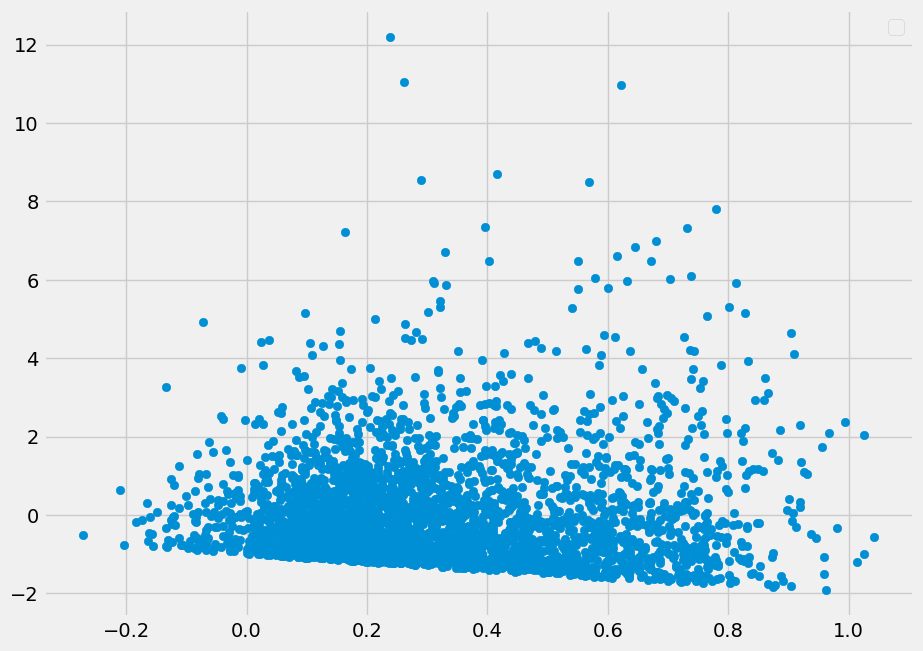

In [33]:
plt.legend()
plt.scatter(draggonpred[0][data4_train["Treat"]==0],residdrag0[data4_train["Treat"]==0])
plt.show()

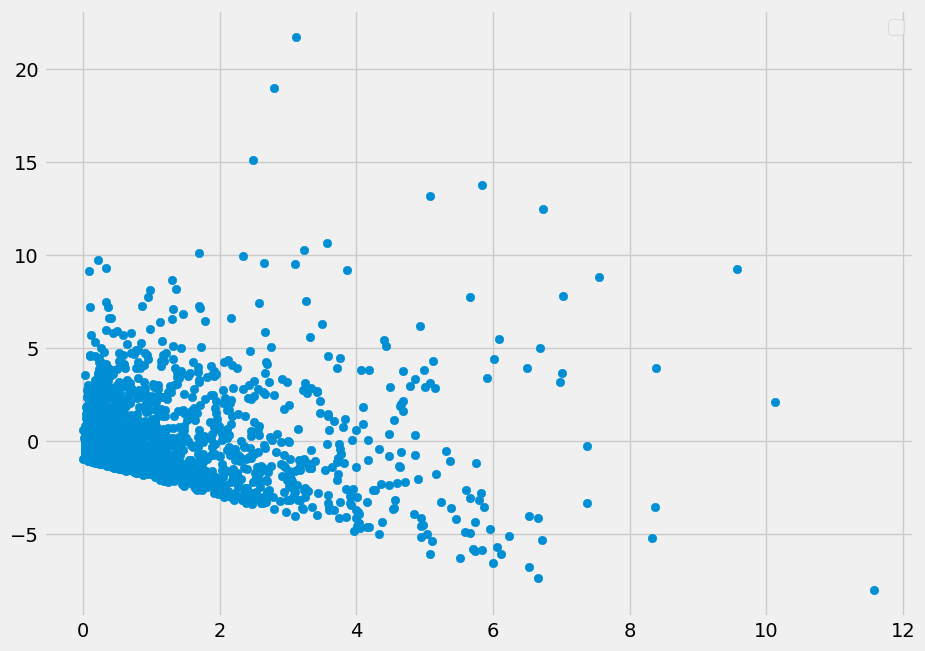

In [34]:
plt.legend()
plt.scatter(draggonpred[1][data4_train["Treat"]==1],residdrag1[data4_train["Treat"]==1])
plt.show()

# Propensity Score vs ITE (IRM)

In [35]:
pscore_irm=pd.DataFrame(np.array(residm3_2))
pscore_irm.columns=list("1")
pscore_irm["1"]=data3_train["Treat"]-pscore_irm["1"]
pscore_irm={"pscore":pscore_irm["1"],
            "ITE":df_preds["IRM"]}
pscore_irm=pd.DataFrame(pscore_irm)
pscore_irm=pscore_irm.sort_values(by="pscore")
pscore_irm["pscore"]=pscore_irm["pscore"]

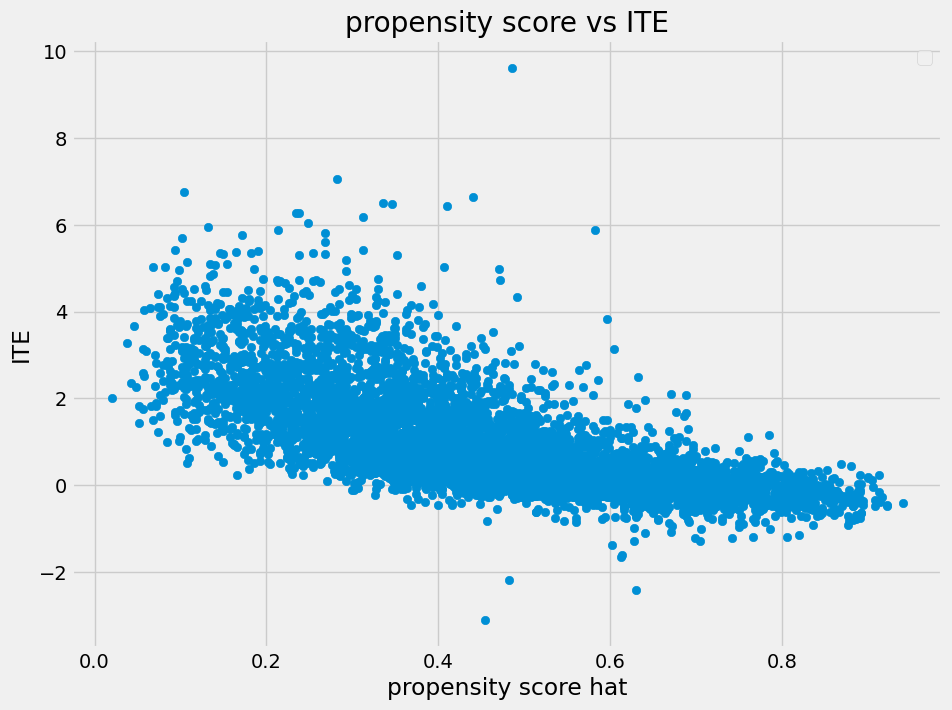

In [36]:
plt.legend()
plt.title('propensity score vs ITE')
plt.xlabel('propensity score hat')
_ =  plt.ylabel('ITE')
plt.scatter(pscore_irm["pscore"],pscore_irm["ITE"])
plt.show()

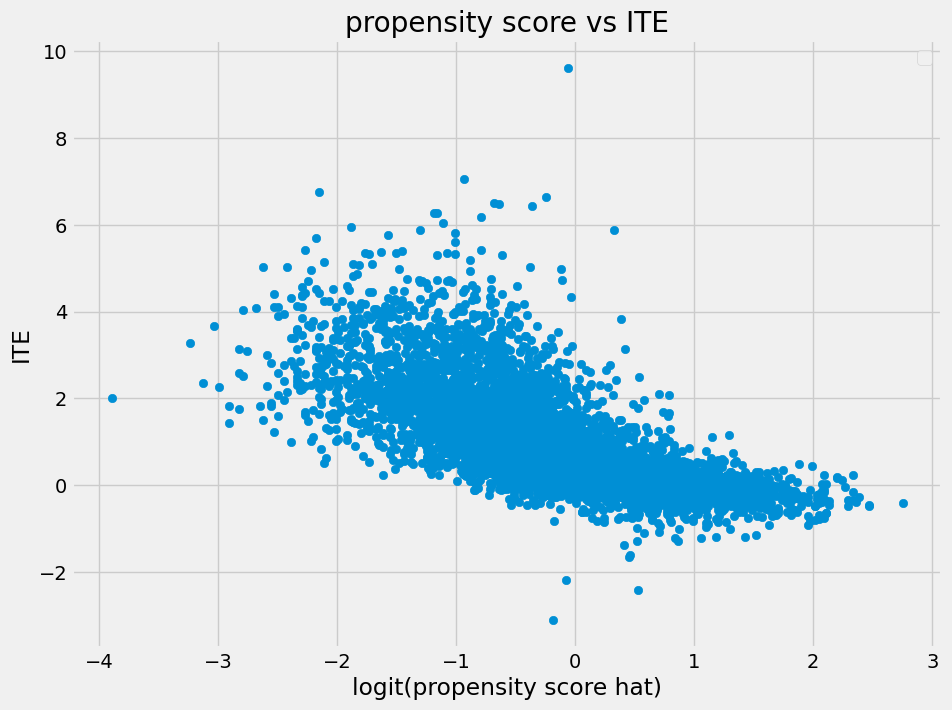

In [37]:
pscore_irm=pd.DataFrame(np.array(residm3_2))
pscore_irm.columns=list("1")
pscore_irm["1"]=data3_train["Treat"]-pscore_irm["1"]
pscore_irm={"pscore":pscore_irm["1"],
            "ITE":df_preds["IRM"]}
pscore_irm=pd.DataFrame(pscore_irm)
pscore_irm=pscore_irm.sort_values(by="pscore")
pscore_irm["pscore"]=np.log(pscore_irm["pscore"]/(1-pscore_irm["pscore"]))

plt.legend()
plt.title('propensity score vs ITE')
plt.xlabel('logit(propensity score hat)')
_ =  plt.ylabel('ITE')
plt.scatter(pscore_irm["pscore"],pscore_irm["ITE"])
plt.show()

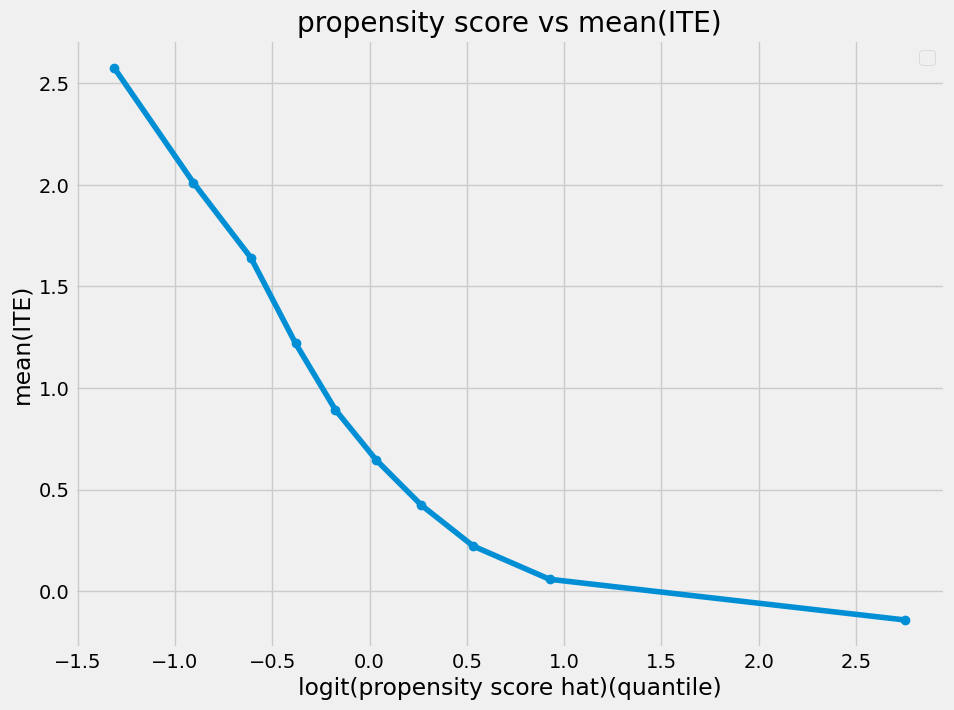

In [38]:
qt=[np.quantile(pscore_irm["pscore"],0),np.quantile(pscore_irm["pscore"],0.1),np.quantile(pscore_irm["pscore"],0.2),\
    np.quantile(pscore_irm["pscore"],0.3),np.quantile(pscore_irm["pscore"],0.4),np.quantile(pscore_irm["pscore"],0.5),\
    np.quantile(pscore_irm["pscore"],0.6),np.quantile(pscore_irm["pscore"],0.7),np.quantile(pscore_irm["pscore"],0.8),\
    np.quantile(pscore_irm["pscore"],0.9),np.quantile(pscore_irm["pscore"],1)]
gate=[0]*10
for i in range(10):
    subgroup=pscore_irm[pscore_irm["pscore"].between(qt[i],qt[i+1])]
    gate[i]=np.average(subgroup["ITE"])
plt.legend()
plt.title('propensity score vs mean(ITE)')
plt.xlabel('logit(propensity score hat)(quantile)')
_ =  plt.ylabel('mean(ITE)')
plt.plot(qt[1:11],gate,marker="o")
plt.show()

In [39]:
# qt=[np.quantile(pscore_irm["pscore"],0),np.quantile(pscore_irm["pscore"],0.1),np.quantile(pscore_irm["pscore"],0.2),\
#     np.quantile(pscore_irm["pscore"],0.3),np.quantile(pscore_irm["pscore"],0.4),np.quantile(pscore_irm["pscore"],0.5),\
#     np.quantile(pscore_irm["pscore"],0.6),np.quantile(pscore_irm["pscore"],0.7),np.quantile(pscore_irm["pscore"],0.8),\
#     np.quantile(pscore_irm["pscore"],0.9),np.quantile(pscore_irm["pscore"],1)]
# gate=[0]*10
# for i in range(10):
#     a0=np.floor(i*n/10)
#     a1=np.floor((i+1)*n/10)
#     if (i*n/10-a0)>0.5:
#         a0=a0+1
#     if ((i+1)*n/10-a1)>0.5:
#         a1=a1+1
#     a1=a1-1
#     a0=int(a0)
#     a1=int(a1)
#     subgroup=pscore_irm[a0:a1]
#     gate[i]=np.average(subgroup["ITE"])
# plt.legend()
# plt.title('propensity score vs ITE')
# plt.xlabel('logit(propensity score hat)')
# _ =  plt.ylabel('ITE')
# plt.plot(qt[1:11],gate)
# plt.show()

# CATE(propencity score)(95%CI may be wrong)

        0         1         2         3         4         5
0     1.0  0.000000  0.000000  0.000000  0.000000  0.000000
1     1.0  0.338339  0.037297  0.000000  0.000000  0.000000
2     1.0  0.376885  0.050002  0.000000  0.000000  0.000000
3     1.0  0.408529  0.063221  0.000000  0.000000  0.000000
4     1.0  0.422216  0.069959  0.000000  0.000000  0.000000
...   ...       ...       ...       ...       ...       ...
5995  1.0  0.000000  0.000000  0.021844  0.280631  0.697525
5996  1.0  0.000000  0.000000  0.019045  0.265066  0.715889
5997  1.0  0.000000  0.000000  0.011511  0.213469  0.775020
5998  1.0  0.000000  0.000000  0.011511  0.213469  0.775020
5999  1.0  0.000000  0.000000  0.000000  0.000000  1.000000

[6000 rows x 6 columns]
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t     P>|t|    [0.025    0.975]
0  0.762931  2.260017  0.337578  0.735693 -3.667515  5.193377
1 -0.432816  2.826676 -

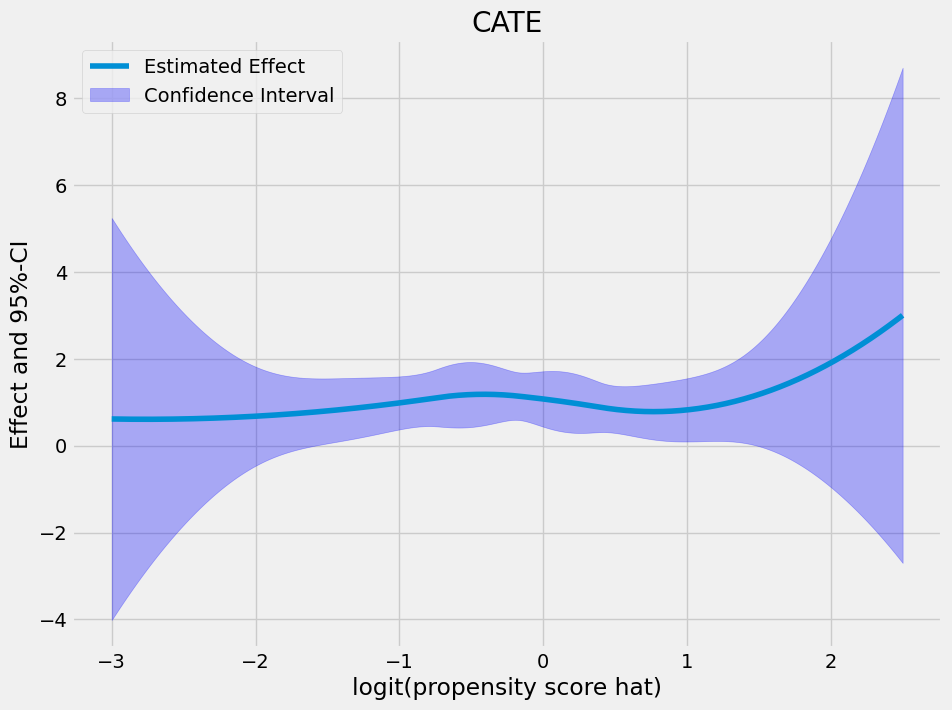

In [40]:
#try------------------------------------------------------------------------------------------------------------
design_matrix = patsy.dmatrix("bs(p, df=5, degree=2)", {"p": pscore_irm["pscore"]})
spline_basis = pd.DataFrame(design_matrix)
print(spline_basis)
cate = dml_irm_obj.cate(spline_basis)
print(cate)

new_data = {"p": np.linspace(-3, 2.5, 350)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
np.random.seed(1212)
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=5000)

#plot cate3-2
plt.rcParams['figure.figsize'] = 10.0, 7.5
df_cate['p'] = new_data['p']
fig, ax = plt.subplots()
ax.plot(df_cate['p'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['p'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('logit(propensity score hat)')
_ =  plt.ylabel('Effect and 95%-CI')
plt.show()


